## Exploratory Data Analysis of given text data for Retrieval-Augmented Generation (RAG) on Policy Documents
---
#### In this notebook following analysis are carried out to understand the content of given policies documents:
- Basic statistics and numbers extrcation: To get the length of the document's content.
- Word cloud analysis: To know the dominant keywords of each document and how each document is similar or different from the other ones.
- Named Entity Extraction using Spacy: To deep dive into data and topic grouping analysis, this provided the insight on whether apart from title of each policy documents is there further segregation is possible between the policy document and thereby ensuring better query response by the RAG assistant application.
- TF-IDF based topic modelling: To find if a unsupervised analysis of the given text corpus when done how many topics does the machine algorithms in text analysis space able to find.
- Sematics Analysis: To find the similarity between the policy documents and sections of policy documents.

#### Finding of the above analysis:

##### - Word Cloud Analysis:
- Dominant words found are data, AI, model, policy, ethics, governance. These are few with high weights.
- It is found that there is high degree of overlap between on the bsis of high weight keywords and after segregating each policy document on the basis of the title of each document further segreagation or effort to find the disimilarity between each document is less likely, this can be concluded based on the keyword analysis as part of this section.

##### - Named Entity Extraction:
- This analysis is done by extracting the standard entity from the text corpus using Spacy library.
- Although the tagging of the extracted entity by the spacy model is incorrect but one key thing is it is consistent.
- I each policy document just like work cloud analysis simialr keyword and phrases are found to be tagged with same entity type. This further confirms the above finding that each of these document are more similar than dissimilar.
- In future scope if the more policy documents are added in RAG assistant appication then the overlap can increase further.

##### - TF-IDF Topic modelling:
- This analysis yield result by applying unsupervised learning analysis.
- In this topic recognition is tried on the text corpus of available policy data to find how much segregation a machine learning algorithm can find.
- Although there are 3 policy document when processed under this analysis yield only 2 topic, this further confirms the high overlap and similarity in the content of the policy documents.

##### - Sematics similarity Analysis:
- In this analysis the similarity between the policy document and the section of the policy documents is generated.
- Its is found that the similarity between different chuncks of policy document have a good similarity score with text chucks from another policy docuemnt:
     
    - ('Policy_2.txt', 1) <-> ('Policy_3.txt', 6) (Score: 0.8027)
    - ('Policy_2.txt', 1) <-> ('Policy_3.txt', 2) (Score: 0.7421)
    - ('Policy_2.txt', 7) <-> ('Policy_3.txt', 6) (Score: 0.7375)
    - ('Policy_2.txt', 2) <-> ('Policy_3.txt', 3) (Score: 0.7327)
    - ('Policy_1.txt', 7) <-> ('Policy_3.txt', 21) (Score: 0.6198)

- This further confirms at sentence level there is high overlap within the text data available for this RAG application.

#### Conclusion & Design desicions:
1. Considering future scope to serve multiple policy document as knwledge base/context for this RAG application assistent the chances of inter policy document content similarity will be high.
2. Such high similarity can reduce the result accuracy of the response gven by the RAG application for a given query.
3. Considering this in this RAG applicatio design it is better to have a intent classifier (text classification) of the incoming question/query by the end user.
4. Alternate to intent classifier can be setting up the context in real-time by asking end user upfront that what are they looking for.
5. ##### Application considerations:
   - The details can be found in the README file of the application.
   - In summary, rather that loading the policy document in the bucket storage, documents are loaded as the markdown file and hosted as github pages.
   - This make the input to the RAG model (mistral, llama etc) consistent. As it is found that in shared policy documents the markdow format is not consistent for heading and subheading. In large corpus it will be heavy processing to clean up the markdown special characters. Also this way ensure even if the plicy document is not markdown adn simple text file then that also can be hosted as github pages and loaded into RAG application by passing it as URL.
   - Few screenshots are attached to explain the POC application functioning.



In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer, util


# Load spaCy langauge model for quick text analysis.
nlp = spacy.load("en_core_web_sm")


# Loading shared policy documents text data file to build the local text corpus.
file_paths = ["Policy_1.txt", "Policy_2.txt", "Policy_3.txt"]
policies = {}

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        policies[file_path] = f.read()

In [ ]:
# Final Markdown Section Parser: Line-by-Line Processing

import re
from typing import Dict, List

def clean_markdown_line(line: str) -> str:
    # Replace \n with space and remove markdown symbols
    line = line.replace("\n", " ").strip()
    line = re.sub(r"[#*]+", "", line)  # remove ##, **, etc.
    line = re.sub(r"\s{2,}", " ", line)  # collapse multiple spaces
    return line.strip()

def parse_markdown_sections_line_by_line(policies: Dict[str, str]) -> Dict[str, List[str]]:
    parsed_policies = {}

    for fname, text in policies.items():
        lines = text.splitlines()
        sections = []
        current_section = []

        for line in lines:
            raw_line = line.strip()
            if not raw_line:
                continue

            # Determine if line starts a new section
            is_new_section = (
                re.match(r"##\s+", raw_line) or
                re.match(r"###\s*\d+\.", raw_line) or
                re.match(r"####\s+\d+\.", raw_line) or
                re.match(r"\*\*\d+\.\s*.+?\*\*", raw_line)
            )

            # Clean and normalize line
            cleaned_line = clean_markdown_line(raw_line)

            if is_new_section:
                if current_section:
                    sections.append(" ".join(current_section).strip())
                    current_section = []
                current_section.append(cleaned_line)
            else:
                current_section.append(cleaned_line)

        if current_section:
            sections.append(" ".join(current_section).strip())

        parsed_policies[fname] = sections

    return parsed_policies




In [ ]:
policy_sections = parse_markdown_sections_line_by_line(policies)

In [ ]:
# Basic Stats
stats = []
for fname, sections in policy_sections.items():
    word_counts = [len(sec.split()) for sec in sections if sec.strip()]
    sentence_counts = [len(re.findall(r'[.!?]', sec)) for sec in sections if sec.strip()]
    stats.append({
        'File': fname,
        'Num Sections': len(sections),
        'Avg Words/Section': sum(word_counts)/len(word_counts),
        'Avg Sentences/Section': sum(sentence_counts)/len(sentence_counts)
    })

df_stats = pd.DataFrame(stats)
print(df_stats)

           File  Num Sections  Avg Words/Section  Avg Sentences/Section
0  Policy_1.txt            10          87.200000               4.800000
1  Policy_2.txt             8          90.625000               5.625000
2  Policy_3.txt            36          27.083333               2.333333


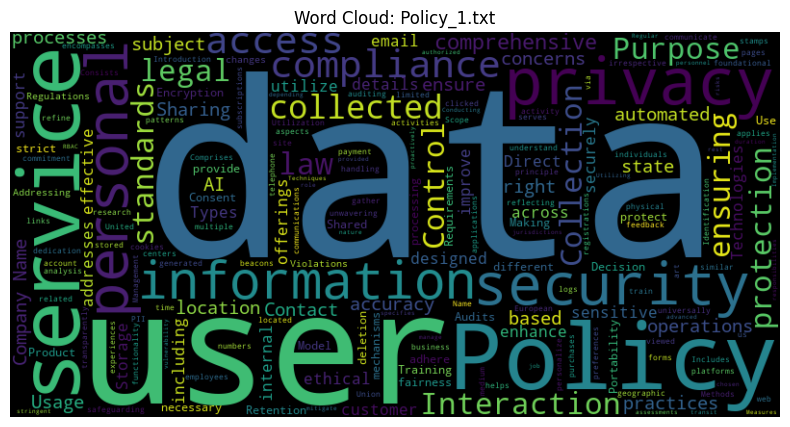

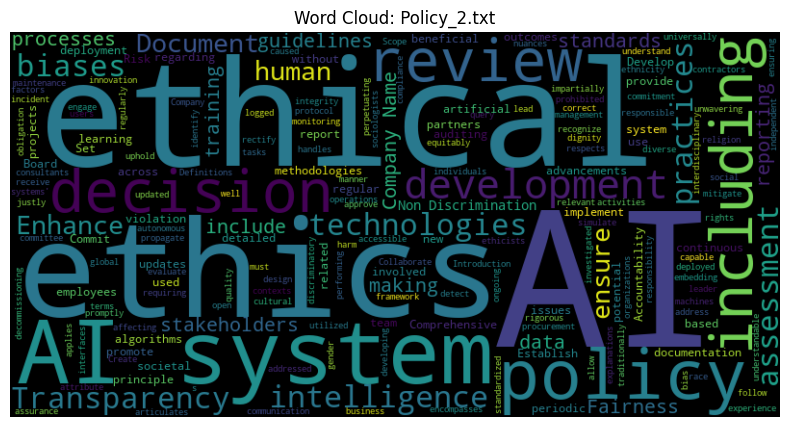

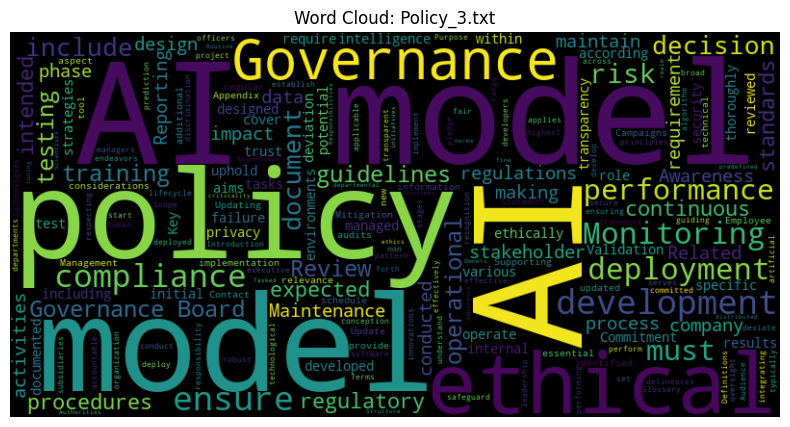

In [ ]:
# Word Clouds
for fname, sections in policy_sections.items():
    text = " ".join(sections)
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {fname}")
    plt.show()

In [ ]:
# NER: Named Entity Recognition
for fname, sections in policy_sections.items():
    print(f"\nEntities in {fname}:")
    for sec in sections:  # Sample only first 3 sections
        doc = nlp(sec)
        for ent in doc.ents:
            print(f"- {ent.text} ({ent.label_})")


Entities in Policy_1.txt:
- Comprehensive Data Privacy (ORG)
- 1 (CARDINAL)
- This Data Privacy Policy (ORG)
- 2 (CARDINAL)
- Data Collection Practices Types of Data (ORG)
- PII (ORG)
- Data Collection (ORG)
- AI (ORG)
- 3 (CARDINAL)
- Data Storage and Management Data Storage Locations: Data (ORG)
- the United States (GPE)
- the European Union (ORG)
- Data Security Measures (ORG)
- RBAC (ORG)
- 4 (CARDINAL)
- Data Usage Internal Use of Data: - Product and Service (ORG)
- AI (GPE)
- 5 (CARDINAL)
- Data Sharing and Disclosure Circumstances Under Which Data (ORG)
- 6 (CARDINAL)
- Data Subjects Access to Data: Users (ORG)
- Data Correction and Deletion (ORG)
- Data Portability (ORG)
- 7 (CARDINAL)
- Policy Enforcement and Compliance Compliance with Laws and Regulations: (ORG)
- GDPR (ORG)
- 8 (CARDINAL)
- Contact Information Contact Details (ORG)
- Data Privacy Policy (ORG)
- Data Protection (ORG)
- 9 (CARDINAL)

Entities in Policy_2.txt:
- Comprehensive AI Ethics (ORG)
- 1 (CARDINAL)
- A

In [ ]:
# TF-IDF + Topic Modeling
texts = [" ".join(policy_sections[f]) for f in file_paths]
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf.fit_transform(texts)
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(tfidf_matrix)


# Top words per topic
terms = tfidf.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{idx}:")
    print([terms[i] for i in topic.argsort()[-10:]])


Topic #0:
['automated', 'accuracy', 'operations', 'contact', 'based', 'processes', 'information', 'security', 'users', 'privacy']

Topic #1:
['intelligence', 'monitoring', 'guidelines', 'deployment', 'models', 'systems', 'model', 'development', 'governance', 'ethics']


In [ ]:
# Embeddings for Semantic Similarity
model = SentenceTransformer('all-MiniLM-L6-v2')
all_chunks = []
chunk_index = []
for fname, sections in policy_sections.items():
    for i, sec in enumerate(sections):
        if len(sec.strip()) > 10:
            all_chunks.append(sec.strip())
            chunk_index.append((fname, i))



embeddings = model.encode(all_chunks, convert_to_tensor=True)
sim_scores = util.pytorch_cos_sim(embeddings, embeddings)

# Find most similar chunks (example)
most_similar = util.paraphrase_mining_embeddings(embeddings, top_k=5)
print("\nTop 5 similar paragraph pairs:")
for score, i, j in most_similar:
    if i != j:
        print(f"\n{chunk_index[i]} <-> {chunk_index[j]} (Score: {score:.4f})")
        print("\nText A:", all_chunks[i][:200], "...\n")
        print("Text B:", all_chunks[j][:200], "...\n")


Top 5 similar paragraph pairs:

('Policy_2.txt', 1) <-> ('Policy_2.txt', 7) (Score: 0.8239)

Text A: 1. Introduction This document articulates [Company Name]'s unwavering commitment to the ethical development, deployment, and management of artificial intelligence (AI). As a leader in AI innovation, w ...

Text B: 7. Review and Updates - Commit to a biannual review cycle for this policy to stay aligned with technological advancements, legal changes, and evolving societal norms regarding AI ethics. Conclusion By ...


('Policy_2.txt', 1) <-> ('Policy_3.txt', 6) (Score: 0.8027)

Text A: 1. Introduction This document articulates [Company Name]'s unwavering commitment to the ethical development, deployment, and management of artificial intelligence (AI). As a leader in AI innovation, w ...

Text B: 2.1 Commitment to Ethical AI Our company is committed to the highest standards of ethical conduct in all our AI endeavors. We pledge to develop and deploy AI technologies that are fair, transpar